In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import rioxarray as rio
import xrspatial.multispectral as ms
from tqdm import tqdm
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load
from odc.algo import to_rgba

with open('../token.txt') as f:
    key = f.read()
pc.settings.set_subscription_key(key)

In [2]:
lat_long = (8.47445853286905, 124.64063461511893) # Lat-Lon centroid location
box_size_deg = 1 # Surrounding box in degrees

# Calculate the Lat-Lon bounding box region
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2
bounds = (min_lon, min_lat, max_lon, max_lat)


time_window="2022-01-01/2022-04-30"
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(collections=["sentinel-2-l2a"], bbox=bounds, datetime=time_window)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 20  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

This is the number of scenes that touch our region: 144


In [ ]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    crs="EPSG:32619", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 1000, "y": 1000},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)

# fig, ax = plt.subplots(figsize=(8, 8))
# xx.isel(time=10)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=3000)
# ax.set_title("RGB Real Color")
# ax.axis('off')
# plt.show()

In [ ]:
display(xx)

In [60]:
def save_dataarray_as_geotiff(data_array, output_filename, resampling=Resampling.nearest):
    # Determine dimensions
    bands, rows, cols = data_array.shape
    
    # Define geotransform parameters
    # Assuming your data array represents a grid of pixels, adjust these parameters accordingly
    pixel_width = 0.01
    pixel_height = 0.01
    transform = from_origin(0, 0, pixel_width, pixel_height)

    # Define metadata
    metadata = {
        'count': bands,  # Number of bands
        'dtype': str(data_array.dtype),  # Data type
        'driver': 'GTiff',  # Output file format
        'height': rows,  # Number of rows
        'width': cols,  # Number of columns
        'transform': transform,  # Affine transformation parameters
        'crs': 'EPSG:4326',  # Coordinate reference system, adjust as needed
    }
    
    with rasterio.open(output_filename, 'w', **metadata) as dst:
        # Iterate over bands
        for band in range(bands):
            # Get the band data
            band_data = data_array[band, :, :]
            
            # Write the band data to the GeoTIFF file
            dst.write(band_data.astype(data_array.dtype), indexes=band + 1)

In [61]:
xxx = xx[['red', 'green', 'blue']].to_array()
xxx.shape

(3, 24, 5567, 5567)

In [63]:
save_dataarray_as_geotiff(xxx[:, 1], 'output2.tif')

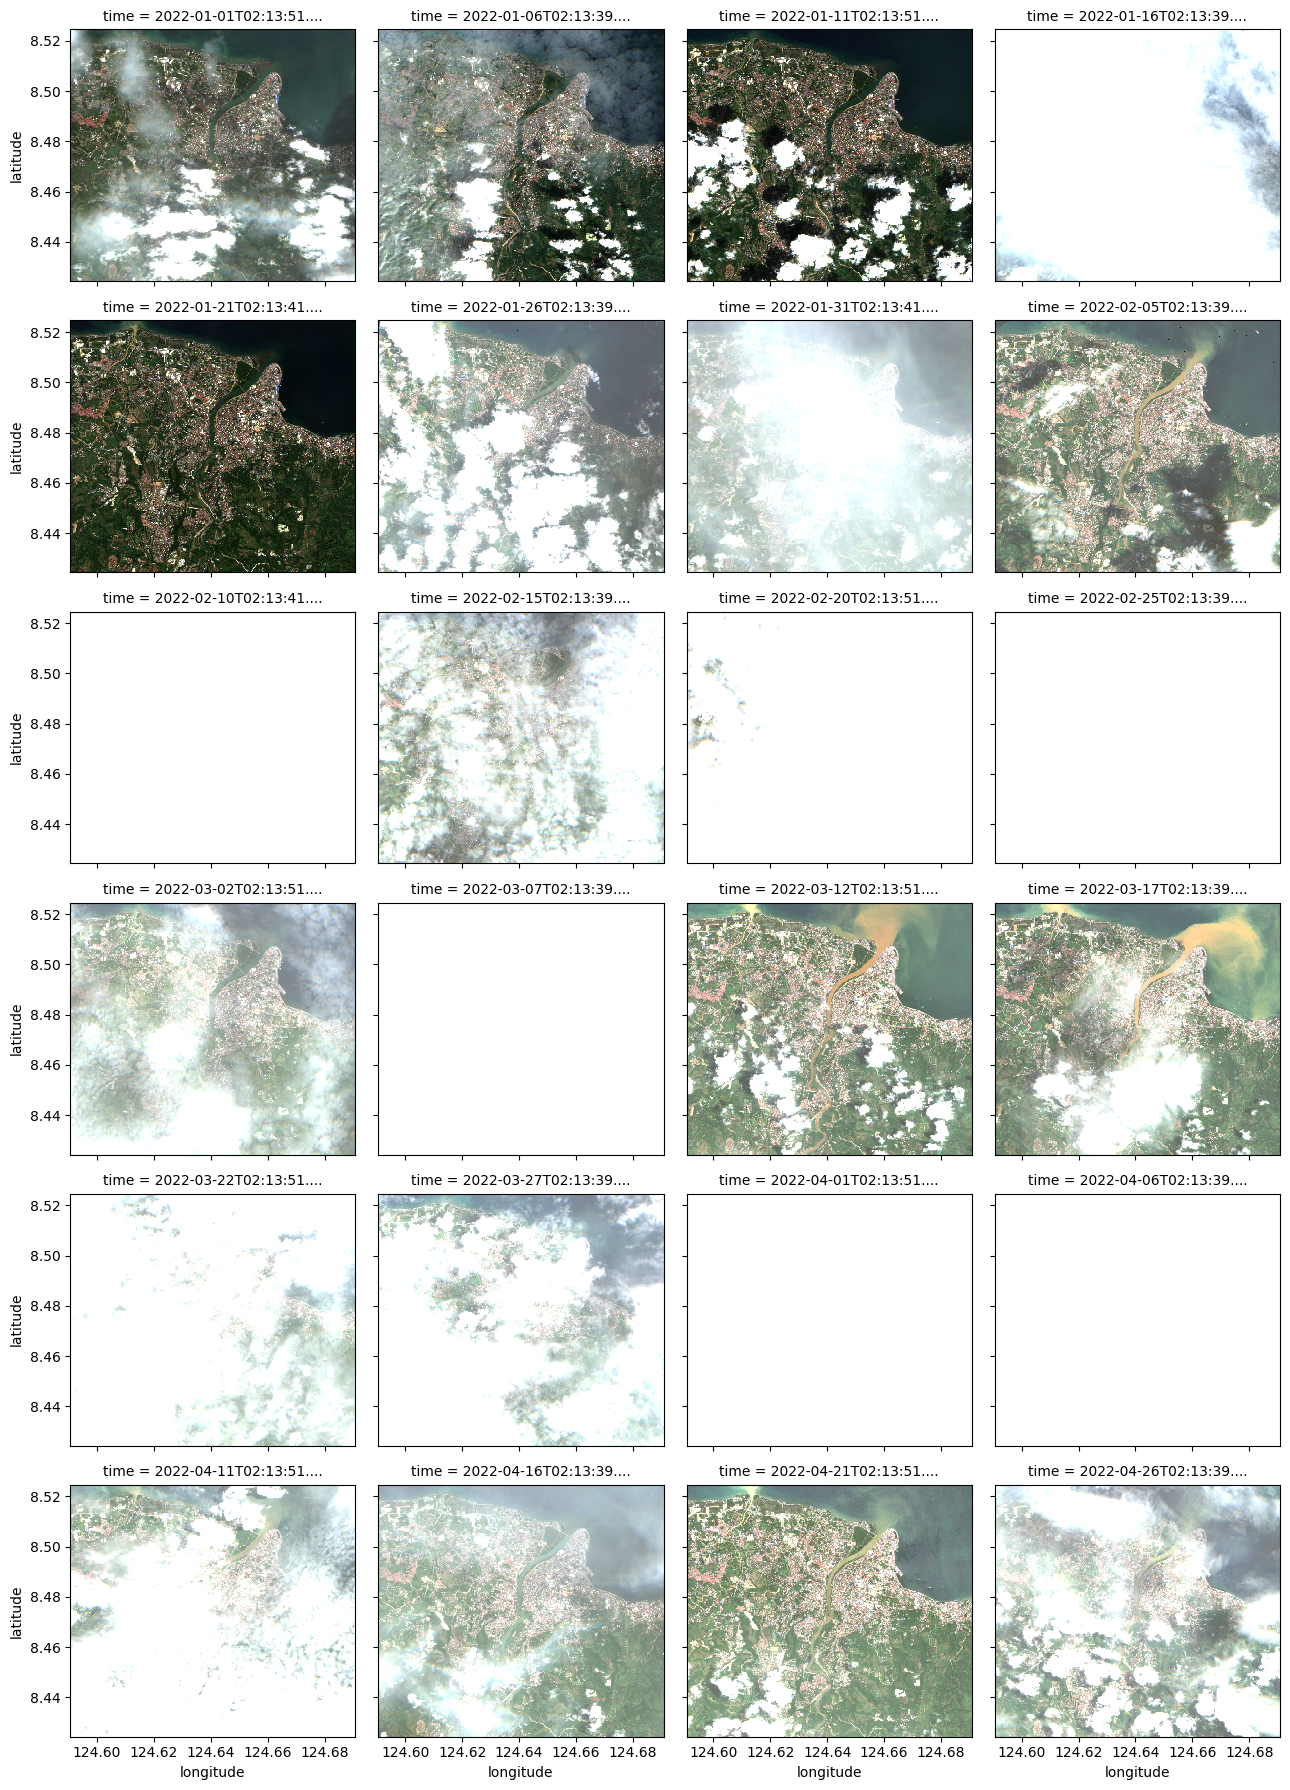

In [23]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=3000)
plt.show()

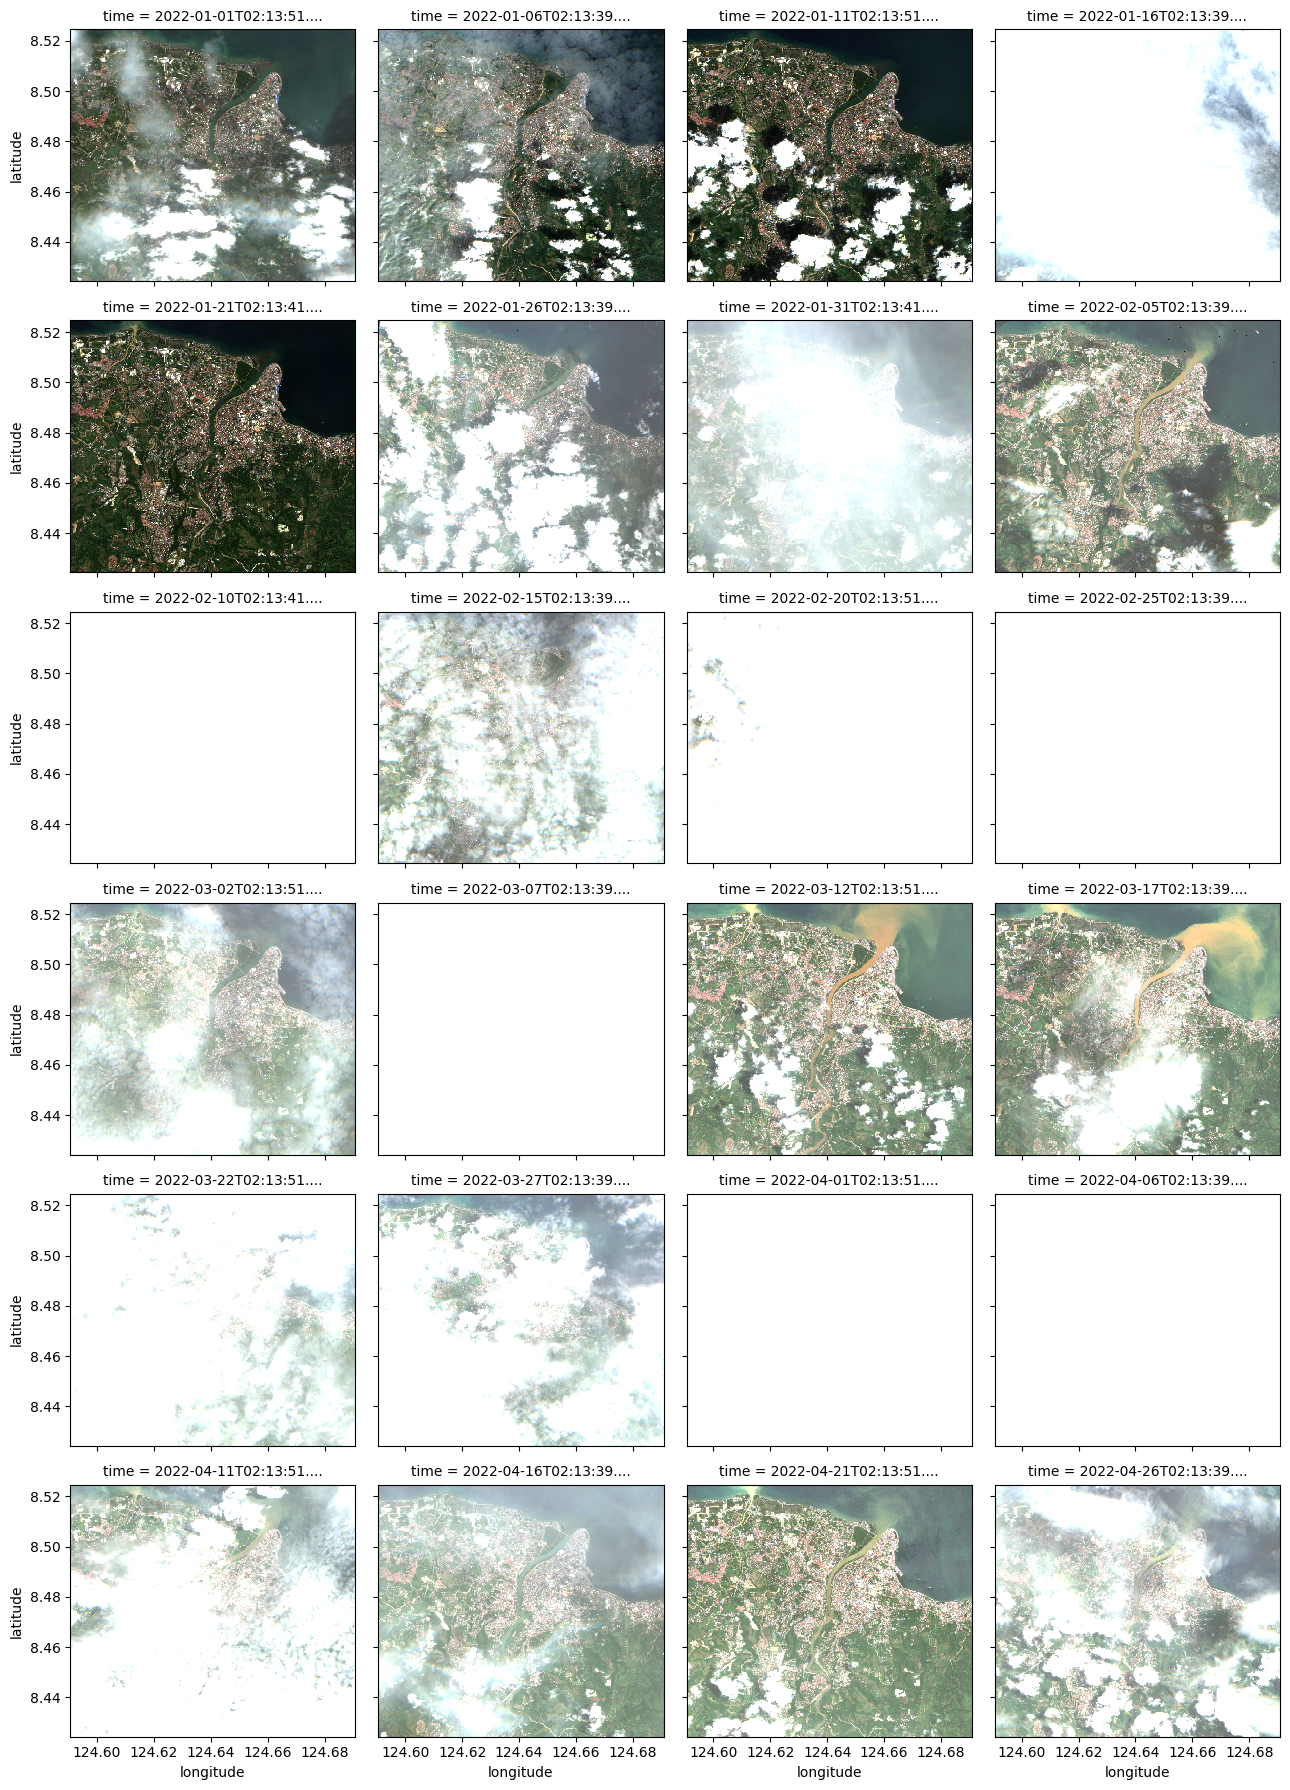

In [17]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=3000)
plt.show()

In [18]:
xxx = xx[["red","green","blue"]].to_array()

In [20]:
xxx

<xarray.DataArray (variable: 3, time: 24, latitude: 558, longitude: 558)> Size: 45MB
dask.array<stack, shape=(3, 24, 558, 558), dtype=uint16, chunksize=(1, 1, 558, 558), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 4kB 8.525 8.524 8.524 ... 8.425 8.425 8.424
  * longitude    (longitude) float64 4kB 124.6 124.6 124.6 ... 124.7 124.7 124.7
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 192B 2022-01-01T02:13:51.024000 ... 20...
  * variable     (variable) object 24B 'red' 'green' 'blue'

In [ ]:
xx.to_netcdf('../data/output_file.nc')